<a href="https://colab.research.google.com/github/hkburwell/Chess-Piece-ID/blob/main/ChessPieceID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 6.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [2]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 1.0MB 24.0MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 92kB 12.8MB/s 
     |████████████████████████████████| 40kB 7.0MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 2.6MB 44.7MB/s 


In [3]:
import fastbook


In [4]:
import torchvision

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [6]:
import os
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [8]:
from PIL import Image

In [9]:
#Changing directory to My Drive
os.chdir('/content/drive/My Drive/Pieces')
!ls

Bishop	export.pkl  King  Knight  models  Pawn	Queen  Rook


In [ ]:
path = '/content/drive/My Drive/Pieces'
pieces = ['Rook','Knight','Bishop','King','Pawn','Queen']

for piece in pieces:
  for filename in os.listdir(path + "/" + piece):
    print (filename)

In [ ]:
fns=[get_image_files(path + "/" + piece) for piece in pieces]
fns

Let's change transparent backgrounds to white backgrounds:

In [ ]:
#Only needed to do this once:
for piece in pieces:
  for pic in os.listdir(path + "/" + piece):
    png = Image.open(path + "/" + piece + "/" + pic).convert('RGBA')
    background = Image.new('RGBA', png.size, (255,255,255))
    alpha_composite = Image.alpha_composite(background, png).convert('RGB')
    alpha_composite.save(path + "/"+ piece + "/" + "EDITED" + pic, 'JPEG', quality=80)
#Now we need to delete all images which don't have EDITED in their filename

In [ ]:
#deleting unedited files
for piece in pieces:
  for pic in os.listdir(path + "/" + piece):
    if 'EDITED' not in (path + "/" + piece + "/" + pic):
      os.remove(path + "/" + piece + "/" + pic) 

In [12]:
#creating a DataBlock
chess_pieces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=40),
    get_y=parent_label,
    item_tfms=Resize(460,method='squish'),
    batch_tfms=[*aug_transforms(size=224,xtra_tfms=None)])
#We avoid cropping images, as this makes it harder to distinguish pieces, ie king/queen and pawn/bishop

In [13]:
#creating a dataloaders
dls = chess_pieces.dataloaders(path)

In [14]:
dls.after_item

Pipeline: Resize -- {'size': (460, 460), 'method': 'squish', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [15]:
dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}

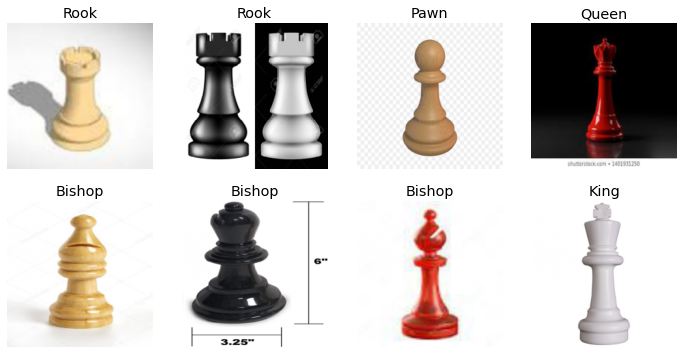

In [16]:
dls.valid.show_batch(max_n=8, nrows=2)

Let's first try a basic architecture, resnet34 for 4 epochs:

In [17]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.862588,1.613233,0.586957,01:26


epoch,train_loss,valid_loss,error_rate,time
0,1.732042,1.120864,0.423913,00:08
1,1.352906,0.742739,0.293478,00:08
2,1.052535,0.520730,0.173913,00:08
3,0.872031,0.490993,0.206522,00:09


We establish a baseline error rate of ~15-20%.

We look at what kind of misclassifications our NN is making:

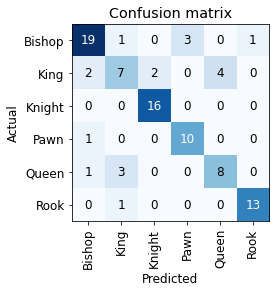

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [19]:
interp.most_confused(min_val=2)

[('King', 'Queen', 4),
 ('Bishop', 'Pawn', 3),
 ('Queen', 'King', 3),
 ('King', 'Bishop', 2),
 ('King', 'Knight', 2)]






Usually, the top mistakes involve (1) K/Q and (2) B/P.

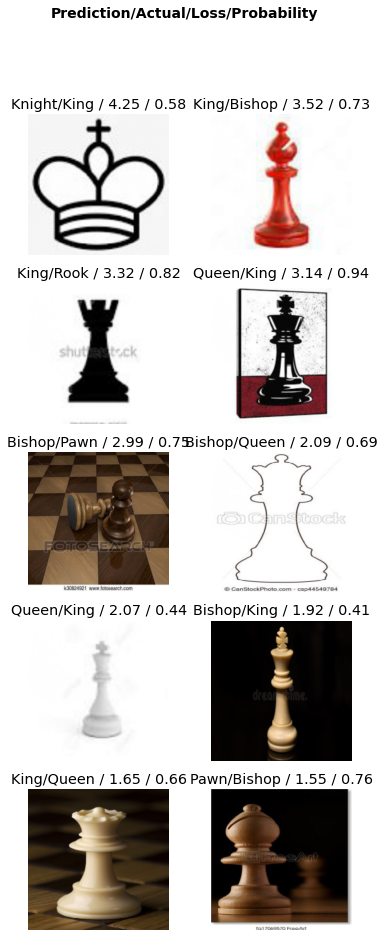

In [20]:
interp.plot_top_losses(10, nrows=5)

Let's try using a learning rate finder to discover a better learning rate:

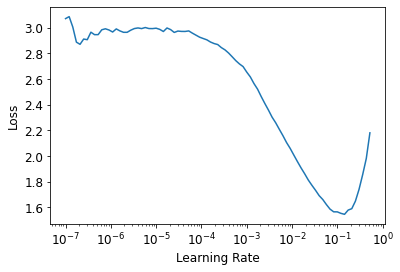

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [22]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.45e-02, steepest point: 1.74e-03


Thus, **1e-3** seems to be a good learning rate. Let's use this learning rate for 15 epochs:

In [23]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(15,base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.070475,2.343406,0.760870,00:08


epoch,train_loss,valid_loss,error_rate,time
0,2.334276,1.782809,0.619565,00:08
1,2.119293,1.411785,0.532609,00:08
2,1.875487,1.039088,0.445652,00:08
3,1.684560,0.748281,0.271739,00:08
4,1.462553,0.567630,0.250000,00:08
5,1.238847,0.463522,0.206522,00:08
6,1.058231,0.398619,0.184783,00:08
7,0.918640,0.355071,0.173913,00:08
8,0.797308,0.353567,0.163043,00:08
9,0.700728,0.356216,0.141304,00:08


Using lrfinder for 15 epochs, we get a slightly improve error rate 

Next, we will explore **freezing/unfreezing** and **discriminative learning rates**.



First, let's try to figure out what a good learning rate will be after unfreezing. To see this:

In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.504018,1.028196,0.402174,00:08
1,1.605755,0.964643,0.250000,00:08
2,1.179742,0.895888,0.195652,00:08


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=6.309573450380412e-07)

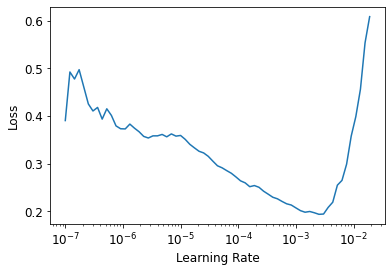

In [26]:
learn.unfreeze()
learn.lr_find()

It seems like 5e-4 is a good lr in this case. With this result, we will use discriminative lr and freezing/unfreezing as follows:

In [27]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 5e-3)
learn.unfreeze()
learn.fit_one_cycle(25, lr_max=slice(5e-5,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.483748,1.374834,0.489130,00:08
1,1.591448,1.170814,0.336957,00:08
2,1.186621,0.859890,0.239130,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.324686,0.784777,0.184783,00:08
1,0.269681,0.776507,0.206522,00:08
2,0.224740,0.736998,0.206522,00:08
3,0.186986,1.206778,0.228261,00:08
4,0.162592,0.924549,0.173913,00:08
5,0.148022,0.408668,0.119565,00:08
6,0.143151,0.408549,0.108696,00:08
7,0.139328,0.725668,0.097826,00:08
8,0.151474,4.445332,0.347826,00:08
9,0.161335,0.918730,0.108696,00:08


It seems like discriminative lr and freezing/unfreezing gives us somewhat better results here (usually in the 3-5% error range).

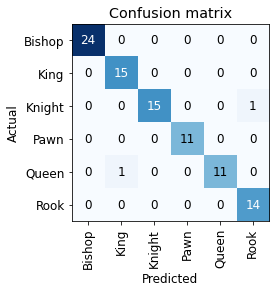

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [29]:
interp.most_confused(min_val=1)

[('Knight', 'Rook', 1), ('Queen', 'King', 1)]

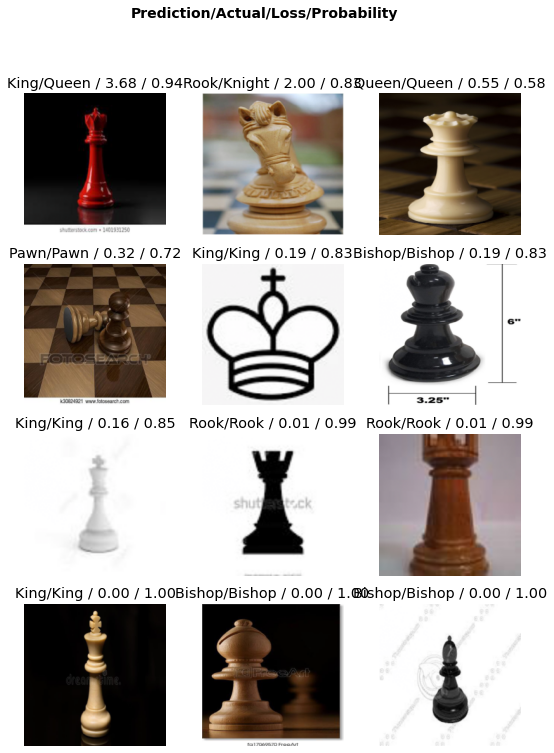

In [30]:
interp.plot_top_losses(12, nrows=4)

Let's now save this architecture with its parameters as above, so that we may run inference.

In [31]:
learn.export()

In [32]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
#Let's look at the 'vocab' of the model:
learn_inf.dls.vocab

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [36]:
#Now, we wish to turn this into an interactive app of sorts
#We start with a button:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
img = PILImage.create(btn_upload.data[-1])

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Bishop; Probability: 1.0000')

In [42]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [45]:
#hide_output
VBox([widgets.Label('Select your piece!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable voila —sys-prefix

  Using cached https://files.pythonhosted.org/packages/13/2f/acbe7006548f3914456ee47f97a2033b1b2f3daf921b12ac94105d87c163/nbconvert-6.0.7-py3-none-any.whl
ERROR: nbdev 1.1.4 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
